In [2]:
#import modules
import xarray as xr
import numpy as np
import pandas as pd
import salem
import plotly.graph_objects as go

import sys
sys.path.append('/exports/csce/datastore/geos/users/s1878599/python_code/')
from WRFChemToolkit.analysis import aerosols_202 as aer, plots as pt, statistics as st, IGP as igp

import warnings
warnings.filterwarnings('ignore')

In [161]:
#Get IGP data for each season
aut_pth='/geos/d21/s1878599/IGP/sims_0304_2020/outputs/autumn/base/wrfout*.nc'
win_pth='/geos/d21/s1878599/IGP/sims_0304_2020/outputs/winter/wrfout*.nc'
mon_pth='/geos/d21/s1878599/IGP/sims_0304_2020/outputs/monsoon/wrfout*.nc'
pmon_pth='/geos/d21/s1878599/IGP/sims_0304_2020/outputs/premonsoon/wrfout*'

# Merge datasets
pm = xr.open_mfdataset(pmon_pth)
m =  xr.open_mfdataset(mon_pth)
a=  xr.open_mfdataset(aut_pth)
w =  xr.open_mfdataset(win_pth)

In [188]:
#Get aerosols
pm_aer=aer.get_aerosols(pm)
m_aer=aer.get_aerosols(m)
a_aer=aer.get_aerosols(a)
w_aer =aer.get_aerosols(w)

In [274]:
def get_delhi(ds):
    return ds.where((28.2< ds.XLAT) & (ds.XLAT< 29) & (76.6 < ds.XLONG) & (ds.XLONG < 77.4), drop=True)

def get_ballia(ds):
    return ds.where((25.45< ds.XLAT) & (ds.XLAT< 26.25) & (83.6 < ds.XLONG) & (ds.XLONG < 84.8), drop=True)

In [295]:
#Get Delhi values 
dpm=get_delhi(pm_aer)
dm=get_delhi(m_aer)
da=get_delhi(a_aer)
dw=get_delhi(w_aer)

#Get Ballia values
bpm=get_ballia(pm_aer)
bm=get_ballia(m_aer)
ba=get_ballia(a_aer)
bw=get_ballia(w_aer)

In [296]:
# Get time avg Delhi
dpmt= dpm.mean(["Time"])
dmt= dm.mean(["Time"])
dat= da.mean(["Time"])
dwt= dw.mean(["Time"])

# Get time and space avg Delhi
dpmts= dpm.mean(["Time","south_north","west_east"])
dmts= dm.mean(["Time","south_north","west_east"])
dats= da.mean(["Time","south_north","west_east"])
dwts= dw.mean(["Time","south_north","west_east"])

In [297]:
# Get time avg Ballia
bpmt= bpm.mean(["Time"])
bmt= bm.mean(["Time"])
bat= ba.mean(["Time"])
bwt= bw.mean(["Time"])

# Get time and space avg Ballia
bpmts= bpm.mean(["Time","south_north","west_east"])
bmts= bm.mean(["Time","south_north","west_east"])
bats= ba.mean(["Time","south_north","west_east"])
bwts= bw.mean(["Time","south_north","west_east"])

# Spatial plots

In [310]:
#SPATIAL PLOT SEASONS

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.colorbar import colorbar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader

def set_formatter(axes):
    for ax in axes:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.5, color='k', alpha=0.4, linestyle='-')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 5, 'color': 'gray'}
        gl.ylabel_style = {'size': 7, 'color': 'grey'} 

        
def set_admin(axes, shp_path):
    for ax,shp in zip(axes,shp_path):
            admin = list(shpreader.Reader(shp).geometries())
            # Add data from Global Administrative Areas Dataset GDAM https://gadm.org/index.html
            ax.add_geometries(admin, ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', alpha=1, lw=0.75)
    

def plot_distr(lat,lon,pmds,mds,ads,wds,var_name,shp,vmax=None,title=None, label=None, cmap="OrRd", levs=10, figsize=[10, 10],format="%.2f"):

    transform=ccrs.Mercator(central_longitude=80.5, min_latitude=15.0, max_latitude=40, latitude_true_scale=30)
    fig, axes =plt.subplots(nrows=4,ncols=1,figsize=figsize, subplot_kw={'projection': transform})
    shp_path=(shp,shp,shp,shp)
    
    set_formatter(axes.flatten())
    set_admin(axes.flatten(), shp_path)
    #Getting values.
    vpm=pmds[var_name][0,:,:].values
    vm= mds[var_name][0,:,:].values
    va= ads[var_name][0,:,:].values
    vw= wds[var_name][0,:,:].values
    if not vmax is None:  # set vmax in the bar to a fixed costumed value (useful to compare consitently different plots).
        vmax=vmax  
    else: 
        import math                # Get the max value in the array to plot.
        vmax =np.array([np.nanmax(vpm),np.nanmax(vm),np.nanmax(va),np.nanmax(vw)]).max()       
       
    vmin=0
    print(vmax)
    levels = np.linspace(vmin, vmax, levs)  # number of levels for which divide the bar. Customised. 
    
    # premonsoon
    cspm=axes[0].pcolormesh(lon,lat,vpm,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax) #U IGP values.
                                                 
    # monsoon
    csm=axes[1].pcolormesh(lon,lat,vm,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax) #U IGP values.
    #autumn
    csa=axes[2].pcolormesh(lon,lat,va,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax) #U IGP values.
    #winter
    csw=axes[3].pcolormesh(lon,lat,vw,transform=ccrs.PlateCarree(),cmap=cmap, vmin=vmin,vmax=vmax) #U IGP values.
    
 
    axes[0].text(-0.4, 0.55, 'PREMONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=axes[0].transAxes)
    axes[1].text(-0.4, 0.55, 'MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=axes[1].transAxes)
    axes[2].text(-0.4, 0.55, 'AUTUMN', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=axes[2].transAxes)
    axes[3].text(-0.4, 0.55, 'WINTER', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=axes[3].transAxes)
    
    #set colorbar
    cax, kw= mpl.colorbar.make_axes([ax for ax in axes.flat], orientation="horizontal", pad=0.035,shrink=.3, format=format)
    cbar=fig.colorbar(csa, cax=cax, **kw)
    if label is not None:
        cbar.set_label(label)
    if title is not None:
        axes[0].set_title(title, fontsize=12,pad=20)
    fig.tight_layout()
    fig.show()

In [279]:
# Def lat lon values and shp files

#Delhi
d_lon =dpm.XLONG.values[0,:,:]
d_lat =dpm.XLAT.values[0,:,:]
delhi_shp =  '/exports/csce/datastore/geos/users/s1878599/python_code/gadm_data/IGP/delhi_urbdistr.shp'

# Ballia
b_lon =bpm.XLONG.values[0,:,:]
b_lat =bpm.XLAT.values[0,:,:]
bal_shp = '/exports/csce/datastore/geos/users/s1878599/python_code/gadm_data/IGP/ballia_rurdistr.shp'

389.9845


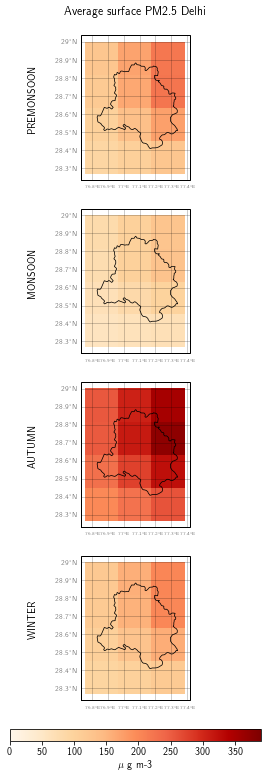

In [333]:
plot_distr(d_lat,d_lon,dpmt,dmt,dat,dwt,"PM2_5_DRY",shp=delhi_shp, title="Average surface PM2.5 Delhi", cmap="OrRd", levs=20, label="$\mu$ g m-3", figsize=[15,15],format="%.f")

269.03296


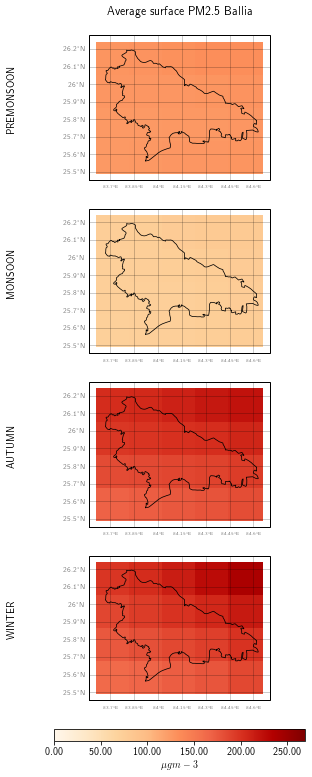

In [334]:
plot_distr(b_lat,b_lon,bpmt,bmt,bat,bwt,"PM2_5_DRY",shp=bal_shp, title="Average surface PM2.5 Ballia", cmap="OrRd", levs=20, label="$\mu g m-3$", figsize=[15,15])

# PM2.5 composition

In [312]:
#Ballia
p25_pmb=[bpmts.pm25_POA.values[0],bpmts.pm25_SOA.values[0],bpmts.pm25_so4.values[0],bpmts.pm25_nh4.values[0],bpmts.pm25_no3.values[0],bpmts.pm25_bc.values[0],bpmts.pm25_dust.values[0],bpmts.pm25_sea.values[0],bpmts.pm25_water.values[0]]
p25_mb= [bmts.pm25_POA.values[0], bmts.pm25_SOA.values[0], bmts.pm25_so4.values[0], bmts.pm25_nh4.values[0], bmts.pm25_no3.values[0], bmts.pm25_bc.values[0], bmts.pm25_dust.values[0], bmts.pm25_sea.values[0], bmts.pm25_water.values[0]]
p25_ab= [bats.pm25_POA.values[0], bats.pm25_SOA.values[0], bats.pm25_so4.values[0], bats.pm25_nh4.values[0], bats.pm25_no3.values[0], bats.pm25_bc.values[0], bats.pm25_dust.values[0], bats.pm25_sea.values[0], bats.pm25_water.values[0]]
p25_wb= [bwts.pm25_POA.values[0], bwts.pm25_SOA.values[0], bwts.pm25_so4.values[0], bwts.pm25_nh4.values[0], bwts.pm25_no3.values[0], bwts.pm25_bc.values[0], bwts.pm25_dust.values[0], bwts.pm25_sea.values[0], bwts.pm25_water.values[0]]

In [313]:
p25_pmd=[dpmts.pm25_POA.values[0],dpmts.pm25_SOA.values[0],dpmts.pm25_so4.values[0],dpmts.pm25_nh4.values[0],dpmts.pm25_no3.values[0],dpmts.pm25_bc.values[0],dpmts.pm25_dust.values[0],dpmts.pm25_sea.values[0],dpmts.pm25_water.values[0]]
p25_md= [dmts.pm25_POA.values[0], dmts.pm25_SOA.values[0], dmts.pm25_so4.values[0], dmts.pm25_nh4.values[0], dmts.pm25_no3.values[0], dmts.pm25_bc.values[0], dmts.pm25_dust.values[0], dmts.pm25_sea.values[0], dmts.pm25_water.values[0]]
p25_ad= [dats.pm25_POA.values[0], dats.pm25_SOA.values[0], dats.pm25_so4.values[0], dats.pm25_nh4.values[0], dats.pm25_no3.values[0], dats.pm25_bc.values[0], dats.pm25_dust.values[0], dats.pm25_sea.values[0], dats.pm25_water.values[0]]
p25_wd= [dwts.pm25_POA.values[0], dwts.pm25_SOA.values[0], dwts.pm25_so4.values[0], dwts.pm25_nh4.values[0], dwts.pm25_no3.values[0], dwts.pm25_bc.values[0], dwts.pm25_dust.values[0], dwts.pm25_sea.values[0], dwts.pm25_water.values[0]]

In [316]:
import plotly.graph_objects as go

bins=['PREMONSOON','MONSOON', 'AUTUMN', 'WINTER']

fig = go.Figure(data=[
    go.Bar(name='POA', x=bins,           y=[p25_pmb[0],p25_mb[0],p25_ab[0],p25_wb[0]],  marker_color="rgb(0,153,76)"),
    go.Bar(name='SOA', x=bins,           y=[p25_pmb[1],p25_mb[1],p25_ab[1],p25_wb[1]], marker_color="rgb(153,255,153)"),
    go.Bar(name='$SO_4^{2-}$', x=bins,   y=[p25_pmb[2],p25_mb[2],p25_ab[2],p25_wb[2]], marker_color="rgb(255,0,0)"),
    go.Bar(name='$NH_4^+$', x=bins,      y=[p25_pmb[3],p25_mb[3],p25_ab[3],p25_wb[3]], marker_color="rgb(255,255,102)"),
    go.Bar(name='$NO_3^-$', x=bins,      y=[p25_pmb[4],p25_mb[4],p25_ab[4],p25_wb[4]], marker_color="rgb(0,76,153)"),
    go.Bar(name='BC', x=bins,            y=[p25_pmb[5],p25_mb[5],p25_ab[5],p25_wb[5]], marker_color="rgb(0,0,0)"),
    go.Bar(name='OTHER', x=bins,         y=[p25_pmb[6],p25_mb[6],p25_ab[6],p25_wb[6]], marker_color="rgb(192,192,192)"),
    go.Bar(name='SEA SALT', x=bins,      y=[p25_pmb[7],p25_mb[7],p25_ab[7],p25_wb[7]], marker_color="rgb(255,204,229)"),
    go.Bar(name='WATER', x=bins,         y=[p25_pmb[8],p25_mb[8],p25_ab[8],p25_wb[8]], marker_color="rgb(153,255,255)")
    ])
    # Change the bar mode
fig.update_layout(barmode='stack',
title="Seasonal pm2.5 composition - Ballia",
yaxis_title="ug/m3")
fig.update_yaxes(range=[0, 300])
fig.show()

In [317]:
import plotly.graph_objects as go

bins=['PREMONSOON','MONSOON', 'AUTUMN', 'WINTER']

fig = go.Figure(data=[
    go.Bar(name='POA', x=bins,           y=[p25_pmd[0],p25_md[0],p25_ad[0],p25_wd[0]],  marker_color="rgb(0,153,76)"),
    go.Bar(name='SOA', x=bins,           y=[p25_pmd[1],p25_md[1],p25_ad[1],p25_wd[1]], marker_color="rgb(153,255,153)"),
    go.Bar(name='$SO_4^{2-}$', x=bins,   y=[p25_pmd[2],p25_md[2],p25_ad[2],p25_wd[2]], marker_color="rgb(255,0,0)"),
    go.Bar(name='$NH_4^+$', x=bins,      y=[p25_pmd[3],p25_md[3],p25_ad[3],p25_wd[3]], marker_color="rgb(255,255,102)"),
    go.Bar(name='$NO_3^-$', x=bins,      y=[p25_pmd[4],p25_md[4],p25_ad[4],p25_wd[4]], marker_color="rgb(0,76,153)"),
    go.Bar(name='BC', x=bins,            y=[p25_pmd[5],p25_md[5],p25_ad[5],p25_wd[5]], marker_color="rgb(0,0,0)"),
    go.Bar(name='OTHER', x=bins,         y=[p25_pmd[6],p25_md[6],p25_ad[6],p25_wd[6]], marker_color="rgb(192,192,192)"),
    go.Bar(name='SEA SALT', x=bins,      y=[p25_pmd[7],p25_md[7],p25_ad[7],p25_wd[7]], marker_color="rgb(255,204,229)"),
    go.Bar(name='WATER', x=bins,         y=[p25_pmd[8],p25_md[8],p25_ad[8],p25_wd[8]], marker_color="rgb(153,255,255)")
    ])
    # Change the bar mode
fig.update_layout(barmode='stack',
title="Seasonal pm2.5 composition - Delhi",
yaxis_title="ug/m3")
fig.update_yaxes(range=[0, 300])
fig.show()

In [321]:
datad = {
    "poa":[p25_pmd[0],p25_md[0],p25_ad[0],p25_wd[0]],
    "soa":[p25_pmd[1],p25_md[1],p25_ad[1],p25_wd[1]],
    "labels": [
        "Premonsoon",
        "Monsoon",
        "Autumn",
        "Winter",
    ]
}

In [326]:
datab = {
    "poa":[p25_pmb[0],p25_mb[0],p25_ab[0],p25_wb[0]],
    "soa":[p25_pmb[1],p25_mb[1],p25_ab[1],p25_wb[1]],
    "labels": [
        "Premonsoon",
        "Monsoon",
        "Autumn",
        "Winter",
    ]
}

In [331]:
data =datab
fig = go.Figure(
    data=[
        go.Bar(
            name="POA",
            x=data["labels"],
            y=data["poa"],
            marker_color="rgb(0,153,76)",
            offsetgroup=0,
            
        ),
          go.Bar(
            name="SOA",
            x=data["labels"],
            y=data["soa"],
            offsetgroup=0,
            marker_color="rgb(0,255,128)",
            base=data["poa"]
          )
    ],
    layout=go.Layout(
        title="Average surface OA Ballia",
        yaxis_title="$\mu g m^{-3}$"
    )
)
fig.update_yaxes(range=[0, 60])
fig.show()

In [335]:
def get_vbs(ds):
    
    #Get only aerosols and gas partitioning. Matrix 2x5
    
    cond_vap=[
        'cvasoaX','cvasoa1','cvasoa2','cvasoa3','cvasoa4',
        'cvbsoaX','cvbsoa1','cvbsoa2','cvbsoa3','cvbsoa4'
        ]
        
    aer = [
        'asoaX','asoa1','asoa2','asoa3','asoa4',
        'bsoaX','bsoa1','bsoa2','bsoa3','bsoa4'
        ]
        
    
    
    for v in aer:
        #sum each aer bin
        ds[v] = ds[v +'_a01'] + ds[v +'_a02'] +ds[v +'_a03']+ ds[v +'_a04']


    vbs= np.array([[(ds.asoaX + ds.bsoaX).values[0],(ds.asoa1 + ds.bsoa1).values[0],(ds.asoa2 + ds.bsoa2).values[0],(ds.asoa3 + ds.bsoa3).values[0],(ds.asoa4 + ds.bsoa4).values[0]],
                  [(ds.cvasoaX + ds.cvbsoaX).values[0],(ds.cvasoa1 + ds.cvbsoa1).values[0],(ds.cvasoa2 + ds.cvbsoa2).values[0],(ds.cvasoa3 + ds.cvbsoa3).values[0],(ds.cvasoa4 + ds.cvbsoa4).values[0]]
                 ])
    
    return vbs   

In [336]:
def plot_vbs(vbs,title):
    
    import plotly.graph_objects as go

    bins=['-4','-3','-2','-1', '0', '1','2', "3"]

    fig = go.Figure(data=[
    go.Bar(name='aerosol', x=bins,  y=[ vbs[0,0], 0, 0, 0, vbs[0,1],vbs[0,2],vbs[0,3],vbs[0,4]], marker_color="rgb(60,179,113)"),
    go.Bar(name='gas', x=bins,  y=[vbs[1,0],0,0,0,vbs[1,1],vbs[1,2],vbs[1,3],vbs[1,4]], marker_color="rgb(255,255,102)"),
    ])
    # Change the bar mode
    fig.update_layout(barmode='stack',
    title=title,
    xaxis_title="log10(C*)",
    yaxis_title="Organic Mass (ug/m3)",)
    fig.update_yaxes(range=[0,10]) #, showgrid=True, gridwidth=0.5, gridcolor="rgb(225,225,225)")#'rgb(224,224,224)')
    #fig.update_layout({
    #"plot_bgcolor": "rgba(0, 0, 0, 0)",
    #"paper_bgcolor": "rgba(0, 0, 0, 0)",
    #})
    fig.show()

In [337]:
pmb_vbs = get_vbs(bpmts)
mb_vbs = get_vbs(bmts)
ab_vbs = get_vbs(bats)
wb_vbs = get_vbs(bwts)

pmd_vbs = get_vbs(dpmts)
md_vbs = get_vbs(dmts)
ad_vbs = get_vbs(dats)
wd_vbs = get_vbs(dwts)